# Neural Networks for MNIST dataset

In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Loading MNIST
Here we load the dataset and create data loaders.

In [3]:
train_ds = datasets.MNIST('../data', train=True, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_ds = datasets.MNIST('../data', train=False, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

Processing...
Done!


In [4]:
batch_size = 64
#batch_size = 5 # for testing
kwargs = {'num_workers': 1, 'pin_memory': True} 

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, **kwargs)

## Looking at Examples

In [5]:
train_dl = iter(train_loader)
x, y = next(train_dl)

In [6]:
print(x.shape, y.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


Helper method (from fast.ai)

In [7]:
def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [8]:
# first from torch to numpy
X = x.numpy(); Y = y.numpy()
X.shape

(64, 1, 28, 28)

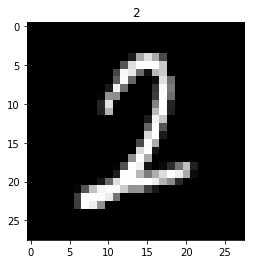

In [9]:
show(X[0][0], Y[0])

In [10]:
print(X[0][0][:4][:4])

[[-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421

## Feed Forward Neural Network

In [18]:
# for the number of neurons in the hidden unit
def get_model(M = 300):
    net = nn.Sequential(nn.Linear(28*28, M),
                        nn.ReLU(),
                        nn.Linear(M, 10))
    return net #.cuda()

In [23]:
def train_model(train_loader, test_loader, num_epochs, model, optimizer):
    model.train()
    sum_loss = 0.0
    total = 0
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            batch = images.shape[0] # size of the batch
            # Convert torch tensor to Variable, change shape of the input
            images = images.view(-1, 28*28) #.cuda()
        
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
        
            total += batch
            sum_loss += batch * loss.item()
            if (i+1) % 100 == 0:
                print ('Epoch [%d/%d], Loss: %.4f' 
                   %(epoch+1, num_epochs, sum_loss/total))
                
        # print train and validation loss per epoch 
        train_loss = sum_loss/total
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, train_loss))
        val_acc, val_loss = model_accuracy_loss(model, test_loader)
        print('Epoch [%d/%d], Valid Accuracy: %.4f, Valid Loss: %.4f' %(epoch+1, num_epochs, val_acc, val_loss))
    return val_acc, val_loss, train_loss

In [32]:
def model_accuracy_loss(model, test_loader):
    model.eval()
    correct = 0
    sum_loss = 0.0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28*28) #.cuda()
        outputs = model(images)
        _, pred = torch.max(outputs, 1)
        loss = F.cross_entropy(outputs, labels)
        sum_loss += labels.size(0)*loss.item()
        total += labels.size(0)
        correct += pred.eq(labels).sum().item()
    return 100 * correct / total, sum_loss/ total

In [33]:
net = get_model()
learning_rate = 0.01
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
model_accuracy_loss(net, test_loader)

(5.98, 2.3405684131622313)

In [34]:
train_model(train_loader, test_loader, num_epochs=2, model=net, optimizer=optimizer)

Epoch [1/2], Loss: 0.5203
Epoch [1/2], Loss: 0.4180
Epoch [1/2], Loss: 0.3701
Epoch [1/2], Loss: 0.3445
Epoch [1/2], Loss: 0.3254
Epoch [1/2], Loss: 0.3109
Epoch [1/2], Loss: 0.3004
Epoch [1/2], Loss: 0.2930
Epoch [1/2], Loss: 0.2854
Epoch [1/2], Loss: 0.2832
Epoch [1/2], Valid Accuracy: 94.5900, Valid Loss: 0.1931
Epoch [2/2], Loss: 0.2777
Epoch [2/2], Loss: 0.2718
Epoch [2/2], Loss: 0.2650
Epoch [2/2], Loss: 0.2629
Epoch [2/2], Loss: 0.2589
Epoch [2/2], Loss: 0.2559
Epoch [2/2], Loss: 0.2536
Epoch [2/2], Loss: 0.2525
Epoch [2/2], Loss: 0.2503
Epoch [2/2], Loss: 0.2490
Epoch [2/2], Valid Accuracy: 94.3300, Valid Loss: 0.2695


(94.33, 0.2694580779347569, 0.24898516967147588)

## Models with L2 regularization
To add L2 regularization use the `weight_decay` argument on the optimizer

In [35]:
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay = 0.01)

## Models with Dropout

In [38]:
def get_model_v2(M = 300, p=0):
    modules = []
    modules.append(nn.Linear(28*28, M))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M, 10))
    return nn.Sequential(*modules) #.cuda()

In [39]:
net2 = get_model_v2(M = 300, p=0.1)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [40]:
train_model(train_loader, test_loader, num_epochs=1, model=net2, optimizer=optimizer)

Epoch [1/1], Loss: 2.2733
Epoch [1/1], Loss: 2.2729
Epoch [1/1], Loss: 2.2728
Epoch [1/1], Loss: 2.2741
Epoch [1/1], Loss: 2.2749
Epoch [1/1], Loss: 2.2742
Epoch [1/1], Loss: 2.2734
Epoch [1/1], Loss: 2.2732
Epoch [1/1], Loss: 2.2737
Epoch [1/1], Loss: 2.2738
Epoch [1/1], Valid Accuracy: 16.7300, Valid Loss: 2.2651


(16.73, 2.265123973464966, 2.273799408976237)

## Experiment 1: learning rate

In [42]:
lr = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

In [ ]:
results = []
for l in lr:
    net = get_model()
    optimizer = optim.Adam(net.parameters(), lr=l)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    results.append((l, val_acc, val_loss, train_loss))

Epoch [1/10], Loss: 1336.2245
Epoch [1/10], Loss: 672.0559
Epoch [1/10], Loss: 450.6313
Epoch [1/10], Loss: 340.5066
Epoch [1/10], Loss: 272.9944
Epoch [1/10], Loss: 228.9794
Epoch [1/10], Loss: 197.8301
Epoch [1/10], Loss: 173.8928
Epoch [1/10], Loss: 155.3980
Epoch [1/10], Loss: 149.3619
Epoch [1/10], Valid Accuracy: 11.8900, Valid Loss: 2.9001
Epoch [2/10], Loss: 135.5759
Epoch [2/10], Loss: 123.8662
Epoch [2/10], Loss: 114.0472
Epoch [2/10], Loss: 105.7008
Epoch [2/10], Loss: 98.5106
Epoch [2/10], Loss: 92.2865
Epoch [2/10], Loss: 86.8035
Epoch [2/10], Loss: 81.9734
Epoch [2/10], Loss: 77.6470
Epoch [2/10], Loss: 76.1929
Epoch [2/10], Valid Accuracy: 10.9400, Valid Loss: 2.7223
Epoch [3/10], Loss: 72.4544
Epoch [3/10], Loss: 69.0755
Epoch [3/10], Loss: 66.0070
Epoch [3/10], Loss: 63.2083
Epoch [3/10], Loss: 60.6445
Epoch [3/10], Loss: 58.3381
Epoch [3/10], Loss: 56.1735
Epoch [3/10], Loss: 54.1629
Epoch [3/10], Loss: 52.2959
Epoch [3/10], Loss: 51.6301
Epoch [3/10], Valid Accuracy:

In [ ]:
results

In [25]:
lr = [0.0006]
results1 = []
for l in lr:
    net = get_model()
    optimizer = optim.Adam(net.parameters(), lr=l)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    results1.append((l, val_acc, val_loss, train_loss))

Epoch [1/10], Loss: 0.6348
Epoch [1/10], Loss: 0.4709
Epoch [1/10], Loss: 0.4031
Epoch [1/10], Loss: 0.3601
Epoch [1/10], Loss: 0.3308
Epoch [1/10], Loss: 0.3067
Epoch [1/10], Loss: 0.2854
Epoch [1/10], Loss: 0.2682
Epoch [1/10], Loss: 0.2565
Epoch [1/10], Loss: 0.2523
Epoch [1/10], Valid Accuracy: 96.1500, Valid Loss: 0.1300
Epoch [2/10], Loss: 0.2393
Epoch [2/10], Loss: 0.2279
Epoch [2/10], Loss: 0.2183
Epoch [2/10], Loss: 0.2098
Epoch [2/10], Loss: 0.2023
Epoch [2/10], Loss: 0.1958
Epoch [2/10], Loss: 0.1896
Epoch [2/10], Loss: 0.1842
Epoch [2/10], Loss: 0.1793
Epoch [2/10], Loss: 0.1777
Epoch [2/10], Valid Accuracy: 96.7700, Valid Loss: 0.0975
Epoch [3/10], Loss: 0.1721
Epoch [3/10], Loss: 0.1670
Epoch [3/10], Loss: 0.1631
Epoch [3/10], Loss: 0.1589
Epoch [3/10], Loss: 0.1549
Epoch [3/10], Loss: 0.1515
Epoch [3/10], Loss: 0.1482
Epoch [3/10], Loss: 0.1454
Epoch [3/10], Loss: 0.1422
Epoch [3/10], Loss: 0.1411
Epoch [3/10], Valid Accuracy: 97.6100, Valid Loss: 0.0794
Epoch [4/10], Lo

In [ ]:
results1

In [ ]:
results1

## Experiment 2:  hidden units

In [27]:
results2 = []
m_arr = [10, 50, 100, 300, 1000, 2000]
for M in m_arr:
    net = get_model(M=M)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    results2.append((M, val_acc, val_loss, train_loss))

Epoch [1/10], Loss: 1.6656
Epoch [1/10], Loss: 1.2958
Epoch [1/10], Loss: 1.0667
Epoch [1/10], Loss: 0.9415
Epoch [1/10], Loss: 0.8556
Epoch [1/10], Loss: 0.7910
Epoch [1/10], Loss: 0.7428
Epoch [1/10], Loss: 0.7059
Epoch [1/10], Loss: 0.6760
Epoch [1/10], Loss: 0.6652
Epoch [1/10], Valid Accuracy: 88.1500, Valid Loss: 0.3978
Epoch [2/10], Loss: 0.6393
Epoch [2/10], Loss: 0.6184
Epoch [2/10], Loss: 0.6013
Epoch [2/10], Loss: 0.5852
Epoch [2/10], Loss: 0.5716
Epoch [2/10], Loss: 0.5576
Epoch [2/10], Loss: 0.5457
Epoch [2/10], Loss: 0.5353
Epoch [2/10], Loss: 0.5262
Epoch [2/10], Loss: 0.5229
Epoch [2/10], Valid Accuracy: 90.2400, Valid Loss: 0.3347
Epoch [3/10], Loss: 0.5132
Epoch [3/10], Loss: 0.5047
Epoch [3/10], Loss: 0.4967
Epoch [3/10], Loss: 0.4894
Epoch [3/10], Loss: 0.4818
Epoch [3/10], Loss: 0.4751
Epoch [3/10], Loss: 0.4681
Epoch [3/10], Loss: 0.4632
Epoch [3/10], Loss: 0.4574
Epoch [3/10], Loss: 0.4555
Epoch [3/10], Valid Accuracy: 91.0700, Valid Loss: 0.3047
Epoch [4/10], Lo

Epoch [6/10], Loss: 0.1172
Epoch [6/10], Loss: 0.1155
Epoch [6/10], Loss: 0.1139
Epoch [6/10], Loss: 0.1125
Epoch [6/10], Loss: 0.1112
Epoch [6/10], Loss: 0.1099
Epoch [6/10], Loss: 0.1086
Epoch [6/10], Loss: 0.1075
Epoch [6/10], Loss: 0.1066
Epoch [6/10], Loss: 0.1063
Epoch [6/10], Valid Accuracy: 96.7100, Valid Loss: 0.1093
Epoch [7/10], Loss: 0.1050
Epoch [7/10], Loss: 0.1037
Epoch [7/10], Loss: 0.1025
Epoch [7/10], Loss: 0.1014
Epoch [7/10], Loss: 0.1004
Epoch [7/10], Loss: 0.0994
Epoch [7/10], Loss: 0.0985
Epoch [7/10], Loss: 0.0975
Epoch [7/10], Loss: 0.0965
Epoch [7/10], Loss: 0.0961
Epoch [7/10], Valid Accuracy: 97.5500, Valid Loss: 0.0892
Epoch [8/10], Loss: 0.0950
Epoch [8/10], Loss: 0.0940
Epoch [8/10], Loss: 0.0931
Epoch [8/10], Loss: 0.0921
Epoch [8/10], Loss: 0.0913
Epoch [8/10], Loss: 0.0906
Epoch [8/10], Loss: 0.0898
Epoch [8/10], Loss: 0.0891
Epoch [8/10], Loss: 0.0883
Epoch [8/10], Loss: 0.0880
Epoch [8/10], Valid Accuracy: 97.7800, Valid Loss: 0.0798
Epoch [9/10], Lo

Epoch [1/10], Loss: 0.4590
Epoch [1/10], Loss: 0.3435
Epoch [1/10], Loss: 0.2942
Epoch [1/10], Loss: 0.2630
Epoch [1/10], Loss: 0.2366
Epoch [1/10], Loss: 0.2194
Epoch [1/10], Loss: 0.2070
Epoch [1/10], Loss: 0.1964
Epoch [1/10], Loss: 0.1857
Epoch [1/10], Loss: 0.1836
Epoch [1/10], Valid Accuracy: 96.5800, Valid Loss: 0.1078
Epoch [2/10], Loss: 0.1737
Epoch [2/10], Loss: 0.1663
Epoch [2/10], Loss: 0.1590
Epoch [2/10], Loss: 0.1533
Epoch [2/10], Loss: 0.1483
Epoch [2/10], Loss: 0.1434
Epoch [2/10], Loss: 0.1406
Epoch [2/10], Loss: 0.1363
Epoch [2/10], Loss: 0.1331
Epoch [2/10], Loss: 0.1321
Epoch [2/10], Valid Accuracy: 97.6400, Valid Loss: 0.0734
Epoch [3/10], Loss: 0.1282
Epoch [3/10], Loss: 0.1245
Epoch [3/10], Loss: 0.1214
Epoch [3/10], Loss: 0.1185
Epoch [3/10], Loss: 0.1160
Epoch [3/10], Loss: 0.1133
Epoch [3/10], Loss: 0.1107
Epoch [3/10], Loss: 0.1090
Epoch [3/10], Loss: 0.1072
Epoch [3/10], Loss: 0.1065
Epoch [3/10], Valid Accuracy: 97.7300, Valid Loss: 0.0774
Epoch [4/10], Lo

In [28]:
results2

[(10, 92.56, 0.25207990093231203, 0.3224965521025658),
 (50, 97.17, 0.10309374520778657, 0.10278669840296109),
 (100, 97.51, 0.09394889478683471, 0.07526484426577885),
 (300, 97.8, 0.09102921969294549, 0.057022458457946776),
 (1000, 97.75, 0.11709378248453141, 0.04995477295068403),
 (2000, 98.08, 0.09440541548728942, 0.050505006278318665)]

## Experiment 3: weight decay  

In [57]:
results3 = []
w_arr = [0, 0.0001, 0.001, 0.01, 0.1, 0.3]
for w in w_arr:
    net = get_model(M=M)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=w)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=20, model=net, optimizer=optimizer)
    results3.append((w, val_acc, val_loss, train_loss))

Epoch [1/20], Loss: 1.2031
Epoch [1/20], Loss: 0.8759
Epoch [1/20], Loss: 0.7273
Epoch [1/20], Loss: 0.6411
Epoch [1/20], Loss: 0.5879
Epoch [1/20], Loss: 0.5496
Epoch [1/20], Loss: 0.5240
Epoch [1/20], Loss: 0.5000
Epoch [1/20], Loss: 0.4819
Epoch [1/20], Loss: 0.4755
Epoch [1/20], Valid Accuracy: 91.1800, Valid Loss: 0.3084
Epoch [2/20], Loss: 0.4584
Epoch [2/20], Loss: 0.4461
Epoch [2/20], Loss: 0.4337
Epoch [2/20], Loss: 0.4231
Epoch [2/20], Loss: 0.4139
Epoch [2/20], Loss: 0.4059
Epoch [2/20], Loss: 0.4002
Epoch [2/20], Loss: 0.3952
Epoch [2/20], Loss: 0.3890
Epoch [2/20], Loss: 0.3878
Epoch [2/20], Valid Accuracy: 91.8200, Valid Loss: 0.2814
Epoch [3/20], Loss: 0.3830
Epoch [3/20], Loss: 0.3774
Epoch [3/20], Loss: 0.3721
Epoch [3/20], Loss: 0.3681
Epoch [3/20], Loss: 0.3640
Epoch [3/20], Loss: 0.3617
Epoch [3/20], Loss: 0.3581
Epoch [3/20], Loss: 0.3560
Epoch [3/20], Loss: 0.3527
Epoch [3/20], Loss: 0.3516
Epoch [3/20], Valid Accuracy: 92.4400, Valid Loss: 0.2728
Epoch [4/20], Lo

Epoch [5/20], Loss: 0.3004
Epoch [5/20], Loss: 0.2999
Epoch [5/20], Valid Accuracy: 93.5000, Valid Loss: 0.2235
Epoch [6/20], Loss: 0.2984
Epoch [6/20], Loss: 0.2965
Epoch [6/20], Loss: 0.2949
Epoch [6/20], Loss: 0.2936
Epoch [6/20], Loss: 0.2925
Epoch [6/20], Loss: 0.2911
Epoch [6/20], Loss: 0.2898
Epoch [6/20], Loss: 0.2889
Epoch [6/20], Loss: 0.2878
Epoch [6/20], Loss: 0.2874
Epoch [6/20], Valid Accuracy: 93.8500, Valid Loss: 0.2184
Epoch [7/20], Loss: 0.2861
Epoch [7/20], Loss: 0.2847
Epoch [7/20], Loss: 0.2834
Epoch [7/20], Loss: 0.2824
Epoch [7/20], Loss: 0.2814
Epoch [7/20], Loss: 0.2806
Epoch [7/20], Loss: 0.2798
Epoch [7/20], Loss: 0.2790
Epoch [7/20], Loss: 0.2778
Epoch [7/20], Loss: 0.2774
Epoch [7/20], Valid Accuracy: 93.8500, Valid Loss: 0.2137
Epoch [8/20], Loss: 0.2760
Epoch [8/20], Loss: 0.2749
Epoch [8/20], Loss: 0.2739
Epoch [8/20], Loss: 0.2732
Epoch [8/20], Loss: 0.2726
Epoch [8/20], Loss: 0.2719
Epoch [8/20], Loss: 0.2711
Epoch [8/20], Loss: 0.2704
Epoch [8/20], Lo

Epoch [10/20], Loss: 0.2697
Epoch [10/20], Loss: 0.2691
Epoch [10/20], Loss: 0.2687
Epoch [10/20], Loss: 0.2679
Epoch [10/20], Loss: 0.2672
Epoch [10/20], Loss: 0.2669
Epoch [10/20], Valid Accuracy: 93.0800, Valid Loss: 0.2362
Epoch [11/20], Loss: 0.2664
Epoch [11/20], Loss: 0.2659
Epoch [11/20], Loss: 0.2653
Epoch [11/20], Loss: 0.2647
Epoch [11/20], Loss: 0.2642
Epoch [11/20], Loss: 0.2636
Epoch [11/20], Loss: 0.2630
Epoch [11/20], Loss: 0.2626
Epoch [11/20], Loss: 0.2620
Epoch [11/20], Loss: 0.2617
Epoch [11/20], Valid Accuracy: 93.8200, Valid Loss: 0.2152
Epoch [12/20], Loss: 0.2611
Epoch [12/20], Loss: 0.2605
Epoch [12/20], Loss: 0.2599
Epoch [12/20], Loss: 0.2594
Epoch [12/20], Loss: 0.2590
Epoch [12/20], Loss: 0.2586
Epoch [12/20], Loss: 0.2581
Epoch [12/20], Loss: 0.2577
Epoch [12/20], Loss: 0.2573
Epoch [12/20], Loss: 0.2571
Epoch [12/20], Valid Accuracy: 93.9500, Valid Loss: 0.2136
Epoch [13/20], Loss: 0.2566
Epoch [13/20], Loss: 0.2562
Epoch [13/20], Loss: 0.2557
Epoch [13/2

Epoch [14/20], Valid Accuracy: 92.7400, Valid Loss: 0.2517
Epoch [15/20], Loss: 0.2925
Epoch [15/20], Loss: 0.2922
Epoch [15/20], Loss: 0.2921
Epoch [15/20], Loss: 0.2918
Epoch [15/20], Loss: 0.2915
Epoch [15/20], Loss: 0.2914
Epoch [15/20], Loss: 0.2911
Epoch [15/20], Loss: 0.2908
Epoch [15/20], Loss: 0.2907
Epoch [15/20], Loss: 0.2907
Epoch [15/20], Valid Accuracy: 92.3600, Valid Loss: 0.2607
Epoch [16/20], Loss: 0.2905
Epoch [16/20], Loss: 0.2902
Epoch [16/20], Loss: 0.2899
Epoch [16/20], Loss: 0.2897
Epoch [16/20], Loss: 0.2896
Epoch [16/20], Loss: 0.2895
Epoch [16/20], Loss: 0.2893
Epoch [16/20], Loss: 0.2892
Epoch [16/20], Loss: 0.2890
Epoch [16/20], Loss: 0.2889
Epoch [16/20], Valid Accuracy: 91.8800, Valid Loss: 0.2684
Epoch [17/20], Loss: 0.2888
Epoch [17/20], Loss: 0.2885
Epoch [17/20], Loss: 0.2883
Epoch [17/20], Loss: 0.2882
Epoch [17/20], Loss: 0.2880
Epoch [17/20], Loss: 0.2879
Epoch [17/20], Loss: 0.2877
Epoch [17/20], Loss: 0.2876
Epoch [17/20], Loss: 0.2874
Epoch [17/2

Epoch [19/20], Loss: 0.4863
Epoch [19/20], Loss: 0.4862
Epoch [19/20], Loss: 0.4860
Epoch [19/20], Loss: 0.4859
Epoch [19/20], Loss: 0.4858
Epoch [19/20], Loss: 0.4859
Epoch [19/20], Valid Accuracy: 89.2200, Valid Loss: 0.4585
Epoch [20/20], Loss: 0.4858
Epoch [20/20], Loss: 0.4858
Epoch [20/20], Loss: 0.4857
Epoch [20/20], Loss: 0.4856
Epoch [20/20], Loss: 0.4856
Epoch [20/20], Loss: 0.4854
Epoch [20/20], Loss: 0.4853
Epoch [20/20], Loss: 0.4853
Epoch [20/20], Loss: 0.4853
Epoch [20/20], Loss: 0.4852
Epoch [20/20], Valid Accuracy: 90.0600, Valid Loss: 0.4491
Epoch [1/20], Loss: 1.5117
Epoch [1/20], Loss: 1.2433
Epoch [1/20], Loss: 1.1243
Epoch [1/20], Loss: 1.0578
Epoch [1/20], Loss: 1.0118
Epoch [1/20], Loss: 0.9847
Epoch [1/20], Loss: 0.9635
Epoch [1/20], Loss: 0.9470
Epoch [1/20], Loss: 0.9333
Epoch [1/20], Loss: 0.9292
Epoch [1/20], Valid Accuracy: 85.6400, Valid Loss: 0.8173
Epoch [2/20], Loss: 0.9196
Epoch [2/20], Loss: 0.9122
Epoch [2/20], Loss: 0.9046
Epoch [2/20], Loss: 0.898

In [58]:
results3

[(0, 93.57, 0.22245801687240602, 0.24091088784734407),
 (0.0001, 94.11, 0.2029248180627823, 0.22553045124461255),
 (0.001, 94.08, 0.20515496377944947, 0.2339285868146022),
 (0.01, 93.05, 0.24554430150985718, 0.28318192809442677),
 (0.1, 90.06, 0.44909947180747983, 0.48524947703679405),
 (0.3, 85.23, 0.7909681858062744, 0.8203767530091604)]

In [62]:
np.around([x[3] for x in results3], decimals=2)

array([0.24, 0.23, 0.23, 0.28, 0.49, 0.82])

## Experiment 4: Dropout  

In [54]:
results4 = []
p_arr = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
for p in p_arr:
    net = get_model_v2(M = 300, p=p)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=20, model=net, optimizer=optimizer)
    results4.append((p, val_acc, val_loss, train_loss))

Epoch [1/20], Loss: 0.5503
Epoch [1/20], Loss: 0.4106
Epoch [1/20], Loss: 0.3523
Epoch [1/20], Loss: 0.3120
Epoch [1/20], Loss: 0.2830
Epoch [1/20], Loss: 0.2612
Epoch [1/20], Loss: 0.2463
Epoch [1/20], Loss: 0.2313
Epoch [1/20], Loss: 0.2192
Epoch [1/20], Loss: 0.2162
Epoch [1/20], Valid Accuracy: 96.9000, Valid Loss: 0.1066
Epoch [2/20], Loss: 0.2050
Epoch [2/20], Loss: 0.1952
Epoch [2/20], Loss: 0.1868
Epoch [2/20], Loss: 0.1794
Epoch [2/20], Loss: 0.1731
Epoch [2/20], Loss: 0.1676
Epoch [2/20], Loss: 0.1626
Epoch [2/20], Loss: 0.1590
Epoch [2/20], Loss: 0.1551
Epoch [2/20], Loss: 0.1538
Epoch [2/20], Valid Accuracy: 97.3600, Valid Loss: 0.0876
Epoch [3/20], Loss: 0.1491
Epoch [3/20], Loss: 0.1449
Epoch [3/20], Loss: 0.1408
Epoch [3/20], Loss: 0.1371
Epoch [3/20], Loss: 0.1336
Epoch [3/20], Loss: 0.1306
Epoch [3/20], Loss: 0.1284
Epoch [3/20], Loss: 0.1259
Epoch [3/20], Loss: 0.1240
Epoch [3/20], Loss: 0.1232
Epoch [3/20], Valid Accuracy: 97.6100, Valid Loss: 0.0781
Epoch [4/20], Lo

Epoch [5/20], Loss: 0.0929
Epoch [5/20], Loss: 0.0924
Epoch [5/20], Valid Accuracy: 97.9400, Valid Loss: 0.0721
Epoch [6/20], Loss: 0.0909
Epoch [6/20], Loss: 0.0895
Epoch [6/20], Loss: 0.0883
Epoch [6/20], Loss: 0.0871
Epoch [6/20], Loss: 0.0861
Epoch [6/20], Loss: 0.0849
Epoch [6/20], Loss: 0.0838
Epoch [6/20], Loss: 0.0829
Epoch [6/20], Loss: 0.0821
Epoch [6/20], Loss: 0.0818
Epoch [6/20], Valid Accuracy: 97.8900, Valid Loss: 0.0745
Epoch [7/20], Loss: 0.0807
Epoch [7/20], Loss: 0.0796
Epoch [7/20], Loss: 0.0786
Epoch [7/20], Loss: 0.0778
Epoch [7/20], Loss: 0.0769
Epoch [7/20], Loss: 0.0760
Epoch [7/20], Loss: 0.0752
Epoch [7/20], Loss: 0.0745
Epoch [7/20], Loss: 0.0737
Epoch [7/20], Loss: 0.0735
Epoch [7/20], Valid Accuracy: 97.8000, Valid Loss: 0.0809
Epoch [8/20], Loss: 0.0728
Epoch [8/20], Loss: 0.0719
Epoch [8/20], Loss: 0.0711
Epoch [8/20], Loss: 0.0703
Epoch [8/20], Loss: 0.0697
Epoch [8/20], Loss: 0.0691
Epoch [8/20], Loss: 0.0685
Epoch [8/20], Loss: 0.0678
Epoch [8/20], Lo

Epoch [10/20], Loss: 0.0629
Epoch [10/20], Loss: 0.0623
Epoch [10/20], Loss: 0.0619
Epoch [10/20], Loss: 0.0613
Epoch [10/20], Loss: 0.0609
Epoch [10/20], Loss: 0.0606
Epoch [10/20], Valid Accuracy: 97.8800, Valid Loss: 0.0896
Epoch [11/20], Loss: 0.0601
Epoch [11/20], Loss: 0.0596
Epoch [11/20], Loss: 0.0591
Epoch [11/20], Loss: 0.0586
Epoch [11/20], Loss: 0.0581
Epoch [11/20], Loss: 0.0577
Epoch [11/20], Loss: 0.0572
Epoch [11/20], Loss: 0.0569
Epoch [11/20], Loss: 0.0566
Epoch [11/20], Loss: 0.0564
Epoch [11/20], Valid Accuracy: 97.9800, Valid Loss: 0.0940
Epoch [12/20], Loss: 0.0560
Epoch [12/20], Loss: 0.0557
Epoch [12/20], Loss: 0.0553
Epoch [12/20], Loss: 0.0550
Epoch [12/20], Loss: 0.0546
Epoch [12/20], Loss: 0.0542
Epoch [12/20], Loss: 0.0539
Epoch [12/20], Loss: 0.0536
Epoch [12/20], Loss: 0.0532
Epoch [12/20], Loss: 0.0531
Epoch [12/20], Valid Accuracy: 97.7400, Valid Loss: 0.0982
Epoch [13/20], Loss: 0.0527
Epoch [13/20], Loss: 0.0523
Epoch [13/20], Loss: 0.0519
Epoch [13/2

Epoch [14/20], Valid Accuracy: 98.1300, Valid Loss: 0.0925
Epoch [15/20], Loss: 0.0517
Epoch [15/20], Loss: 0.0513
Epoch [15/20], Loss: 0.0510
Epoch [15/20], Loss: 0.0507
Epoch [15/20], Loss: 0.0503
Epoch [15/20], Loss: 0.0500
Epoch [15/20], Loss: 0.0498
Epoch [15/20], Loss: 0.0495
Epoch [15/20], Loss: 0.0494
Epoch [15/20], Loss: 0.0493
Epoch [15/20], Valid Accuracy: 97.3700, Valid Loss: 0.1311
Epoch [16/20], Loss: 0.0491
Epoch [16/20], Loss: 0.0488
Epoch [16/20], Loss: 0.0485
Epoch [16/20], Loss: 0.0483
Epoch [16/20], Loss: 0.0480
Epoch [16/20], Loss: 0.0478
Epoch [16/20], Loss: 0.0476
Epoch [16/20], Loss: 0.0473
Epoch [16/20], Loss: 0.0471
Epoch [16/20], Loss: 0.0470
Epoch [16/20], Valid Accuracy: 98.1200, Valid Loss: 0.1029
Epoch [17/20], Loss: 0.0467
Epoch [17/20], Loss: 0.0465
Epoch [17/20], Loss: 0.0462
Epoch [17/20], Loss: 0.0460
Epoch [17/20], Loss: 0.0458
Epoch [17/20], Loss: 0.0455
Epoch [17/20], Loss: 0.0453
Epoch [17/20], Loss: 0.0452
Epoch [17/20], Loss: 0.0450
Epoch [17/2

Epoch [19/20], Loss: 0.0490
Epoch [19/20], Loss: 0.0488
Epoch [19/20], Loss: 0.0486
Epoch [19/20], Loss: 0.0484
Epoch [19/20], Loss: 0.0482
Epoch [19/20], Loss: 0.0482
Epoch [19/20], Valid Accuracy: 97.6300, Valid Loss: 0.1252
Epoch [20/20], Loss: 0.0480
Epoch [20/20], Loss: 0.0478
Epoch [20/20], Loss: 0.0476
Epoch [20/20], Loss: 0.0473
Epoch [20/20], Loss: 0.0471
Epoch [20/20], Loss: 0.0469
Epoch [20/20], Loss: 0.0468
Epoch [20/20], Loss: 0.0465
Epoch [20/20], Loss: 0.0463
Epoch [20/20], Loss: 0.0463
Epoch [20/20], Valid Accuracy: 98.0400, Valid Loss: 0.1009
Epoch [1/20], Loss: 1.4547
Epoch [1/20], Loss: 1.1951
Epoch [1/20], Loss: 1.0653
Epoch [1/20], Loss: 0.9956
Epoch [1/20], Loss: 0.9408
Epoch [1/20], Loss: 0.9030
Epoch [1/20], Loss: 0.8748
Epoch [1/20], Loss: 0.8531
Epoch [1/20], Loss: 0.8347
Epoch [1/20], Loss: 0.8277
Epoch [1/20], Valid Accuracy: 92.1900, Valid Loss: 0.2717
Epoch [2/20], Loss: 0.7727
Epoch [2/20], Loss: 0.7240
Epoch [2/20], Loss: 0.6820
Epoch [2/20], Loss: 0.644

In [44]:
results4

[(0, 97.84, 0.08808912643790245, 0.05614798774098356),
 (0.1, 97.61, 0.09669651129245758, 0.05707139935180545),
 (0.3, 97.92, 0.09248216817378997, 0.059961967696944875),
 (0.5, 98.25, 0.07356521678566932, 0.06768945455502719),
 (0.7, 97.99, 0.08513789457678794, 0.08025095816460749),
 (0.9, 98.19, 0.06823221430256962, 0.13839061084330082)]

In [53]:
np.around([x[3] for x in results4], decimals=2)

array([0.06, 0.06, 0.06, 0.07, 0.08, 0.14])

In [51]:
?np.around
